In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

In [5]:
# load the mnist dataset

def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

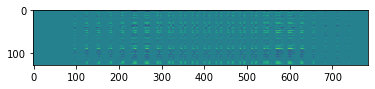

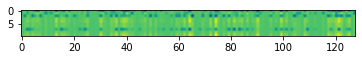

In [12]:
# numpy forward and backward pass
samp = [0, 1, 2, 3]

def logsumexp(x):
  c = x.max(axis=1)
  return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
  # training
  out = np.zeros((len(y), 10), np.float32)
  out[range(out.shape[0]), y] = 1
  
  # forward pass
  x_l1 = x.dot(l1)
  x_relu = np.maximum(x_l1, 0)
  x_l2 = x_relu.dot(l2)
  x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
  x_loss = (-out * x_lsm).mean(axis=1)
  
  # backward pass
  # will involve x_lsm, x_l2, out, d_out and produce dx_sum
  d_out = -out / len(y)
  
  # derivate of logsoftmax
  dx_lsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))
  
  # derivative of l2
  d_l2 = x_relu.T.dot(dx_lsm)
  dx_relu = dx_lsm.dot(l2.T)
  
  # deriavative of relu
  dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu
  
  # derivate of l1
  d_l1 = x.T.dot(dx_l1)
  
  return x_loss, x_l2, d_l1, d_l2

def layer_init(m, h):
  ret = np.random.uniform(-1., 1., size=(m, h)) / np.sqrt(m*h)
  return ret.astype(np.float32)

# init
np.random.seed(1337)
l1 = layer_init(28*28, 128)
l2 = layer_init(128, 10)

x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)),
                                            Y_test[samp])

plt.imshow(d_l1.T)
plt.figure()
plt.imshow(d_l2.T)

loss 0.01 accuracy 0.98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.80it/s]


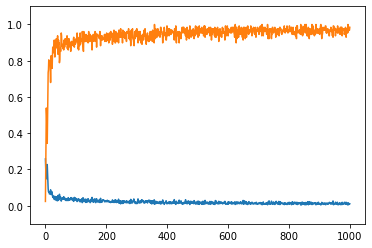

In [22]:
# numpy training
def layer_init(m, h):
  ret = np.random.uniform(-1., 1., size=(m, h)) / np.sqrt(m*h)
  return ret.astype(np.float32)

# reinit
np.random.seed(42)
l1 = layer_init(28*28, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = X_train[samp].reshape((-1, 28*28))
  Y = Y_train[samp]
  x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
  
  cat = np.argmax(x_l2, axis=1)
  accuracy = (cat == Y).mean()
  
  # SGD
  l1 = l1 - lr*d_l1
  l2 = l2 - lr*d_l2
  
  loss = x_loss.mean()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [21]:
# eval
def forward(x):
  x = x.dot(l1)
  x = np.maximum(x, 0)
  x = x.dot(l2)
  return x

Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test == Y_test_preds).mean()

0.9635

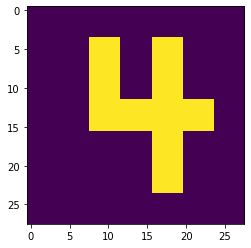

In [24]:
# for fun, can it recognize 4?
m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]

# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
plt.imshow(m.reshape(28, 28))

(4, 4)

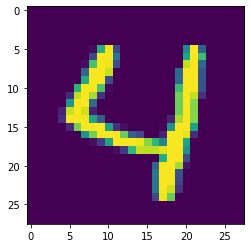

In [34]:
# manualy check
random_test_index = np.random.randint(X_test.shape[0])
test = X_test[random_test_index]
test = test.reshape((28, 28))
plt.imshow(test)

x = test.reshape(1, -1).dot(l1)
x = np.maximum(x, 0)
x = x.dot(l2)
np.argmax(x), Y_test[random_test_index]